# Sky-anisotropy tutorial

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sky_anisotropy as sa
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from bokeh.io import output_notebook

from dask.distributed import LocalCluster, Client, progress

%matplotlib inline

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
cluster = LocalCluster(n_workers=3, threads_per_worker=1)
cluster

In [6]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:55452 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 6.44 GB


In [7]:
nside = 64
npix = hp.nside2npix(nside)

In [8]:
values = np.random.randn(npix)
pix = np.arange(npix)

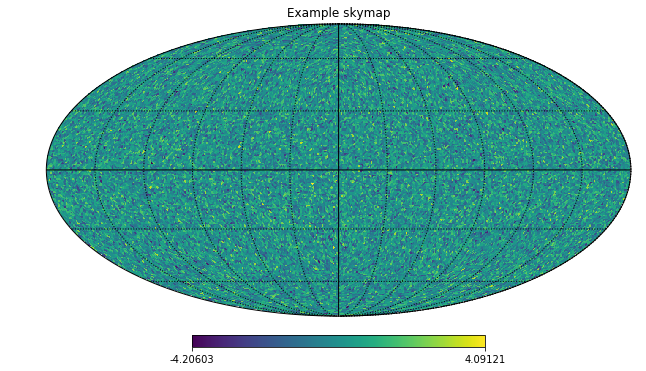

In [9]:
hp.mollview(values, title='Example skymap')
hp.graticule(verbose=False)

## On regions

Two types of on regions are currently supported:

- Disc &mdash; circular region on the sky
- Square &mdash; square region on the sky

Each of these has a corresponding function in `sky_anisotropy`. 

Let's start by picking a healpy pixel to center our example on regions on. Here we'll choose to center the on regions at $\mathrm{(theta, phi) = (60^{\circ}, 70^{\circ})}$.

In [10]:
theta, phi = np.deg2rad(60), np.deg2rad(70)
pix_center = hp.ang2pix(nside, theta, phi)
pix_center

12209

We'll also choose the size of our on regions to be $\mathrm{10^{\circ}}$. 

In [11]:
size = np.deg2rad(10)

### Disc on region

In [12]:
disc_on_region_mask = sa.disc_on_region(pix, pix_center, size=size, nside=nside)

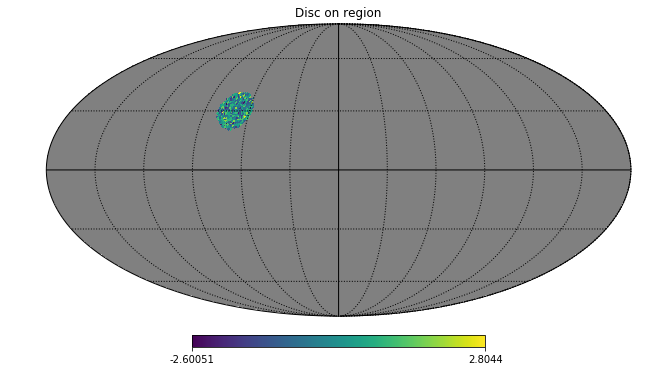

In [13]:
disc_on_region = values.copy()
disc_on_region[~disc_on_region_mask] = hp.UNSEEN
hp.mollview(disc_on_region, title='Disc on region')
hp.graticule(verbose=False)

### Square on region

In [14]:
square_on_region_mask = sa.square_on_region(pix, pix_center, size=size, nside=nside)

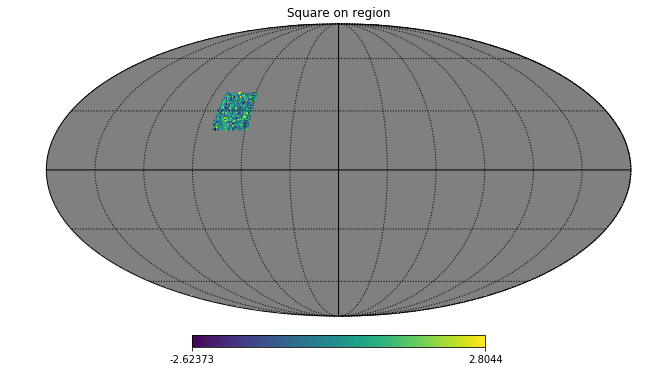

In [15]:
square_on_region = values.copy()
square_on_region[~square_on_region_mask] = hp.UNSEEN
hp.mollview(square_on_region, title='Square on region')
hp.graticule(verbose=False)

## Off regions

Three types of off regions are currently supported:

- All-sky &mdash; all pixels that aren't in the on region
- Theta band &mdash; all pixels that aren't in the on region and are within the the same theta range as the on region
- Opposite &mdash; $\mathrm{180^{\circ}}$ rotation in phi of the on region 

Each of these has a corresponding function in `sky_anisotropy`.

### All-sky off region

In [16]:
allsky_off_region_mask = sa.allsky_off_region(pix, pix_center, disc_on_region_mask, nside=nside)

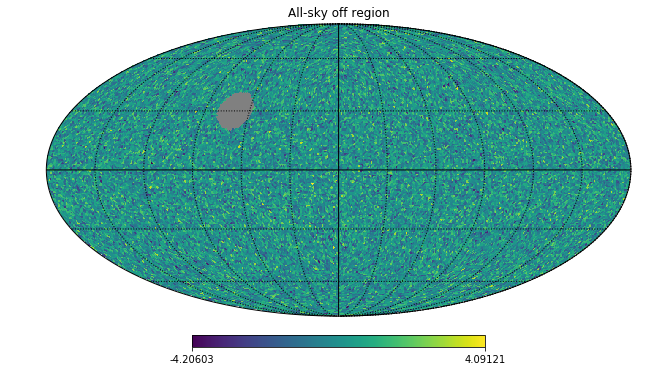

In [17]:
all_sky_off_region = values.copy()
all_sky_off_region[~allsky_off_region_mask] = hp.UNSEEN
hp.mollview(all_sky_off_region, title='All-sky off region')
hp.graticule(verbose=False)

### Theta band off region

In [18]:
theat_band_off_region_mask = sa.theta_band_off_region(pix, pix_center, disc_on_region_mask, nside=nside)

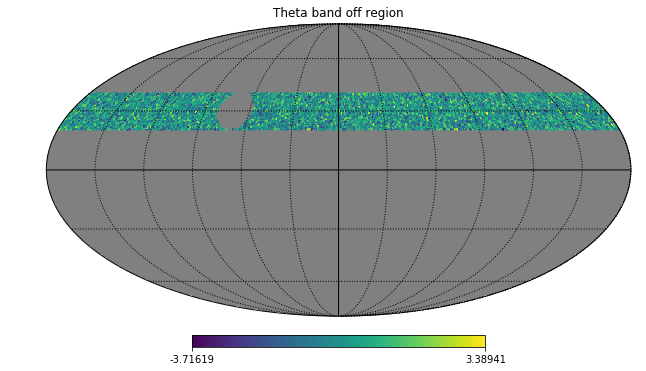

In [19]:
theta_band_off_region = values.copy()
theta_band_off_region[~theat_band_off_region_mask] = hp.UNSEEN
hp.mollview(theta_band_off_region, title='Theta band off region')
hp.graticule(verbose=False)

### Opposite off region

In [20]:
opposite_off_region_mask = sa.opposite_off_region(pix, pix_center, disc_on_region_mask, nside=nside)

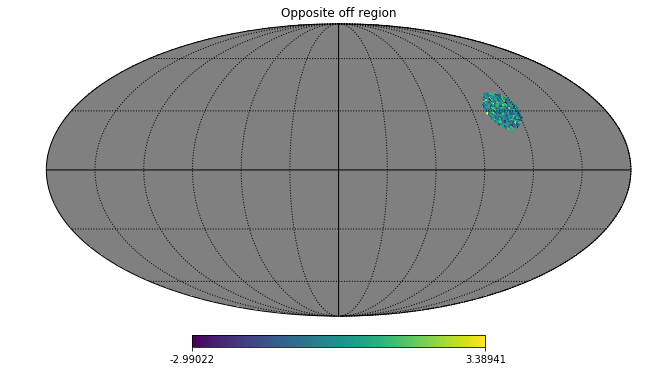

In [21]:
opposite_off_region = values.copy()
opposite_off_region[~opposite_off_region_mask] = hp.UNSEEN
hp.mollview(opposite_off_region, title='Opposite off region')
hp.graticule(verbose=False)

## On-off region $\mathrm{\chi^2}$ comparisons

In [22]:
results = sa.on_off_chi_squared(values, pix,
                                pix_center=pix[:1000],
                                on_region='disc',
                                size=size,
                                off_region='allsky',
                                nside=64,
                                bins=np.linspace(-2, 2, 10),
                                compute=False)

In [23]:
results

Delayed('from_records-90873b71-e082-407f-84e6-687d271ab988')

In [24]:
results_future = client.compute(results)

In [25]:
progress(results_future)

VBox()

In [26]:
df = results_future.result()
df.head()

,alpha,chi2,num_on,pix_center,pval,sig
0,0.007468,7.941743,348,0,0.540028,-0.100503
1,0.007490,8.282509,349,1,0.505946,-0.014905
2,0.007425,6.007524,346,2,0.739165,-0.640773
3,0.007490,6.181119,349,3,0.721663,-0.587790
4,0.007468,10.798306,348,4,0.289788,0.554005


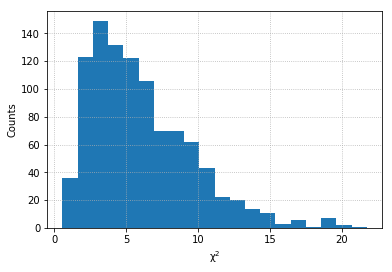

In [27]:
fig, ax = plt.subplots()
df['chi2'].plot(kind='hist', bins=20, ax=ax)
ax.set_xlabel('$\mathrm{\chi^2}$')
ax.set_ylabel('Counts')
ax.grid(ls=':')
plt.show()